<a href="https://colab.research.google.com/github/MiladShahabadi/recommendation-system-using-collaborative-filtering/blob/main/recommendation_system_using_collaborative_filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="alert alert-success">
    <h1 align="center"> Project: recommendation system using collaborative filtering</h1>
    <h3 align="center"> Milad Shahabadi </a></h3>
</div>


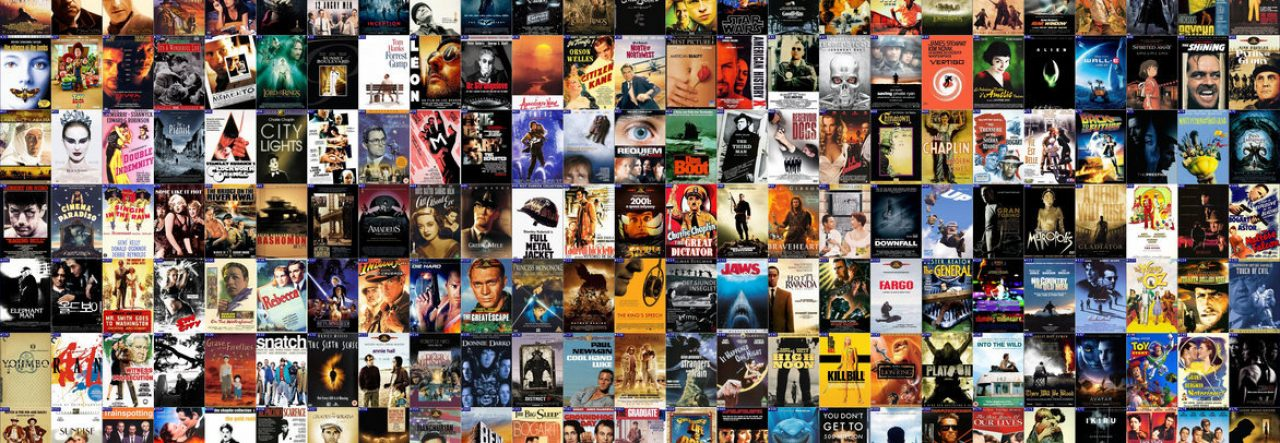

### Table of contents

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a href="#ref1">Acquiring the Data</a></li>
        <li><a href="#ref2">Preprocessing</a></li>
        <li><a href="#ref3">Content-Based Filtering</a></li>
    </ol>
</div>
<br>


# <a id="ref1"></a>

# Acquiring the Data


In [ ]:
To acquire and extract the data, simply run the following Bash scripts:\
Dataset acquired from [GroupLens](http://grouplens.org/datasets/movielens/?utm_medium=Exinfluencer\&utm_source=Exinfluencer\&utm_content=000026UJ\&utm_term=10006555\&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01). Let's download the dataset. To download the data, we will use **`!wget`** to download it from IBM Object Storage.\
**Did you know?** When it comes to Machine Learning, you will likely be working with large datasets. As a business, where can you host your data? IBM is offering a unique opportunity for businesses, with 10 Tb of IBM Cloud Object Storage: [Sign up now for free](http://cocl.us/ML0101EN-IBM-Offer-CC)


In [2]:
!wget -O moviedataset.zip https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%205/data/moviedataset.zip
print('unziping ...')
!unzip -o -j moviedataset.zip 

--2022-06-24 18:43:59--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%205/data/moviedataset.zip
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 160301210 (153M) [application/zip]
Saving to: ‘moviedataset.zip’

moviedataset.zip    100%[===================>] 152.88M  31.9MB/s    in 4.8s    

2022-06-24 18:44:05 (31.9 MB/s) - ‘moviedataset.zip’ saved [160301210/160301210]

unziping ...
Archive:  moviedataset.zip
  inflating: links.csv               
  inflating: movies.csv              
  inflating: ratings.csv             
  inflating: README.txt              
  inflating: tags.csv        

<a id="ref2"></a>

# Preprocessing


In [3]:
#Dataframe manipulation library
import pandas as pd
#Math functions, we'll only need the sqrt function so let's import only that
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
#Storing the movie information into a pandas dataframe
movies_df = pd.read_csv('movies.csv')
#Storing the user information into a pandas dataframe
ratings_df = pd.read_csv('ratings.csv')
#Head is a function that gets the first N rows of a dataframe. N's default is 5.
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


remove the year from the **title** column and store in a new **year** column.


In [5]:
#Using regular expressions to find a year stored between parentheses
#We specify the parantheses so we don't conflict with movies that have years in their titles
movies_df['year'] = movies_df.title.str.extract('(\(\d\d\d\d\))',expand=False)
#Removing the parentheses
movies_df['year'] = movies_df.year.str.extract('(\d\d\d\d)',expand=False)
#Removing the years from the 'title' column
movies_df['title'] = movies_df.title.str.replace('(\(\d\d\d\d\))', '')
#Applying the strip function to get rid of any ending whitespace characters that may have appeared
movies_df['title'] = movies_df['title'].apply(lambda x: x.strip())
movies_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys


,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


 split the values in the **Genres** column into a **list of Genres** 

In [6]:
#Every genre is separated by a | so we simply have to call the split function on |
movies_df['genres'] = movies_df.genres.str.split('|')
movies_df.head()

,movieId,title,genres,year
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995
4,5,Father of the Bride Part II,[Comedy],1995


 use the One Hot Encoding technique 

In [7]:
#Copying the movie dataframe into a new one since we won't need to use the genre information in our first case.
moviesWithGenres_df = movies_df.copy()

#For every row in the dataframe, iterate through the list of genres and place a 1 into the corresponding column
for index, row in movies_df.iterrows():
    for genre in row['genres']:
        moviesWithGenres_df.at[index, genre] = 1
#Filling in the NaN values with 0 to show that a movie doesn't have that column's genre
moviesWithGenres_df = moviesWithGenres_df.fillna(0)
moviesWithGenres_df.head()

,movieId,title,genres,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men,"[Comedy, Romance]",1995,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Father of the Bride Part II,[Comedy],1995,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,169,2.5,1204927694
1,1,2471,3.0,1204927438
2,1,48516,5.0,1204927435
3,2,2571,3.5,1436165433
4,2,109487,4.0,1436165496


 We won't be needing the timestamp column, so drop it


In [9]:
#Drop removes a specified row or column from a dataframe
ratings_df = ratings_df.drop('timestamp', 1)
ratings_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


,userId,movieId,rating
0,1,169,2.5
1,1,2471,3.0
2,1,48516,5.0
3,2,2571,3.5
4,2,109487,4.0


<a id="ref3"></a>

# Content-Based recommendation system


In [10]:
userInput = [
            {'title':'Breakfast Club, The', 'rating':5},
            {'title':'Toy Story', 'rating':3.5},
            {'title':'Jumanji', 'rating':2},
            {'title':"Pulp Fiction", 'rating':5},
            {'title':'Akira', 'rating':4.5}
         ] 
inputMovies = pd.DataFrame(userInput)
inputMovies

,title,rating
0,"Breakfast Club, The",5.0
1,Toy Story,3.5
2,Jumanji,2.0
3,Pulp Fiction,5.0
4,Akira,4.5


#### Add movieId to input user
 


In [11]:
#Filtering out the movies by title
inputId = movies_df[movies_df['title'].isin(inputMovies['title'].tolist())]
#Then merging it so we can get the movieId. It's implicitly merging it by title.
inputMovies = pd.merge(inputId, inputMovies)
#Dropping information we won't use from the input dataframe
inputMovies = inputMovies.drop('genres', 1).drop('year', 1)
#Final input dataframe
#If a movie you added in above isn't here, then it might not be in the original 
#dataframe or it might spelled differently, please check capitalisation.
inputMovies

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


,movieId,title,rating
0,1,Toy Story,3.5
1,2,Jumanji,2.0
2,296,Pulp Fiction,5.0
3,1274,Akira,4.5
4,1968,"Breakfast Club, The",5.0


In [12]:
#Filtering out the movies from the input
userMovies = moviesWithGenres_df[moviesWithGenres_df['movieId'].isin(inputMovies['movieId'].tolist())]
userMovies

,movieId,title,genres,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
293,296,Pulp Fiction,"[Comedy, Crime, Drama, Thriller]",1994,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1246,1274,Akira,"[Action, Adventure, Animation, Sci-Fi]",1988,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1885,1968,"Breakfast Club, The","[Comedy, Drama]",1985,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
#Resetting the index to avoid future issues
userMovies = userMovies.reset_index(drop=True)
#Dropping unnecessary issues due to save memory and to avoid issues
userGenreTable = userMovies.drop('movieId', 1).drop('title', 1).drop('genres', 1).drop('year', 1)
userGenreTable

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.


,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
inputMovies['rating']

0    3.5
1    2.0
2    5.0
3    4.5
4    5.0
Name: rating, dtype: float64

In [15]:
#Dot produt to get weights
userProfile = userGenreTable.transpose().dot(inputMovies['rating'])
#The user profile
userProfile

Adventure             10.0
Animation              8.0
Children               5.5
Comedy                13.5
Fantasy                5.5
Romance                0.0
Drama                 10.0
Action                 4.5
Crime                  5.0
Thriller               5.0
Horror                 0.0
Mystery                0.0
Sci-Fi                 4.5
IMAX                   0.0
Documentary            0.0
War                    0.0
Musical                0.0
Western                0.0
Film-Noir              0.0
(no genres listed)     0.0
dtype: float64

In [16]:
#Now let's get the genres of every movie in our original dataframe
genreTable = moviesWithGenres_df.set_index(moviesWithGenres_df['movieId'])
#And drop the unnecessary information
genreTable = genreTable.drop('movieId', 1).drop('title', 1).drop('genres', 1).drop('year', 1)
genreTable.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.


,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
movieId,,,,,,,,,,,,,,,,,,,,
1,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
genreTable.shape

(34208, 20)

In [18]:
#Multiply the genres by the weights and then take the weighted average
recommendationTable_df = ((genreTable*userProfile).sum(axis=1))/(userProfile.sum())
recommendationTable_df.head()

movieId
1    0.594406
2    0.293706
3    0.188811
4    0.328671
5    0.188811
dtype: float64

In [19]:
#Sort our recommendations in descending order
recommendationTable_df = recommendationTable_df.sort_values(ascending=False)
#Just a peek at the values
recommendationTable_df.head()

movieId
5018      0.748252
26093     0.734266
27344     0.720280
148775    0.685315
6902      0.678322
dtype: float64

 recommendation table


In [20]:
#The final recommendation table
movies_df.loc[movies_df['movieId'].isin(recommendationTable_df.head(20).keys())]

,movieId,title,genres,year
664,673,Space Jam,"[Adventure, Animation, Children, Comedy, Fanta...",1996
1824,1907,Mulan,"[Adventure, Animation, Children, Comedy, Drama...",1998
2902,2987,Who Framed Roger Rabbit?,"[Adventure, Animation, Children, Comedy, Crime...",1988
4923,5018,Motorama,"[Adventure, Comedy, Crime, Drama, Fantasy, Mys...",1991
6793,6902,Interstate 60,"[Adventure, Comedy, Drama, Fantasy, Mystery, S...",2002
8605,26093,"Wonderful World of the Brothers Grimm, The","[Adventure, Animation, Children, Comedy, Drama...",1962
8783,26340,"Twelve Tasks of Asterix, The (Les douze travau...","[Action, Adventure, Animation, Children, Comed...",1976
9296,27344,Revolutionary Girl Utena: Adolescence of Utena...,"[Action, Adventure, Animation, Comedy, Drama, ...",1999
9825,32031,Robots,"[Adventure, Animation, Children, Comedy, Fanta...",2005
11716,51632,Atlantis: Milo's Return,"[Action, Adventure, Animation, Children, Comed...",2003
